In [1]:
import matplotlib.pyplot as plt
import csv

In [4]:
global_min = torch.tensor([-710., -501., -708.])
global_max = torch.tensor([670., 544., 655.])
regression = True
ybatchNormalize = True
y_mean = 18.33333396911621
y_std = 9.783748626708984

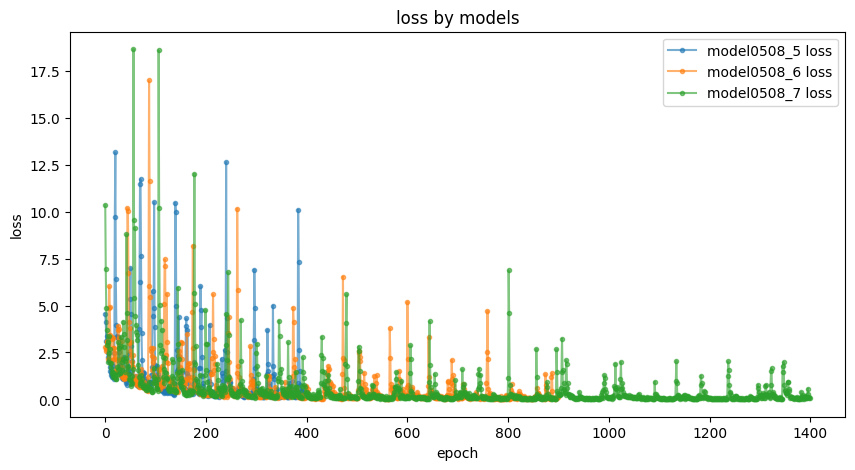

In [2]:
log_paths = ["./models/model0508_5/log.csv","./models/model0508_6/log.csv","./models/model0508_7/log.csv"]

plt.figure(figsize=(10, 5))

for log_path in log_paths:
    f = open(log_path,'r',encoding='UTF8')
    data = csv.reader(f,delimiter=',')
    next(data)

    log_data = []
    log_label = []
    for row in data:
        log_label.append(row[0])
        log_data.append(round(float(row[1]),4))
    f.close()

    
    plt.plot( log_data[100:],linestyle='-', marker='.', label = log_path.split('/')[2] + ' loss', alpha=0.6)
    plt.xlabel('epoch')
    plt.ylabel('loss')

plt.title('loss by models')
plt.legend()    
plt.show()

    

In [12]:
from data_utils import *

import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from model import InceptionNetwork
import matplotlib.pyplot  as plt
import csv

regression = True
ybatchNormalize = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


data_paths = [
    "data/train/exp_1_DAY8",
    "data/train/exp_1_DAY12",
    "data/train/exp_1_DAY15",
    "data/train/exp_1_DAY21",
    "data/train/exp_1_DAY24",
    "data/train/exp_1_DAY27",
    "data/train/exp_1_DAY30",
    "data/train/exp_2_DAY8",
    "data/train/exp_2_DAY12",
    "data/train/exp_2_DAY15",
    "data/train/exp_2_DAY21",
    "data/train/exp_2_DAY24",
    "data/train/exp_2_DAY27",
    "data/train/exp_2_DAY30",
    "data/train/exp_3_DAY8",
    "data/train/exp_3_DAY12",
    "data/train/exp_3_DAY15",
    "data/train/exp_3_DAY21",
    "data/train/exp_3_DAY24",
    "data/train/exp_3_DAY27",
    "data/train/exp_3_DAY30",
    "data/train/exp_4_DAY8",
    "data/train/exp_4_DAY12",
    "data/train/exp_4_DAY15",
    "data/train/exp_4_DAY21",
    "data/train/exp_4_DAY24",
    "data/train/exp_4_DAY27",
    "data/train/exp_4_DAY30",

    ]
# day_values = sorted(set(folder.split("DAY")[-1] for folder in data_paths))
day_values = ["8", "12", "15", "21", "24", "27", "30"]
folder2label = {folder: int(folder.split("DAY")[-1]) for folder in data_paths}
label2name = {int(day_values[idx]): day for idx, day in enumerate(day_values)}

dataset = PaddedTimeSeriesDataset(data_paths, folder2label, global_min = global_min, global_max = global_max, regression=regression)  # 여러 폴더 지정 가능
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_regression)

print(folder2label)
print(label2name)


y_all = torch.cat([y for _, y in dataloader], dim=0)
y_mean = y_all.mean()
y_std = y_all.std()
print(f"y_mean: {y_mean}, y_std: {y_std}")

def test_model(model, dataloader, print_prediction=False):
    print("device:", device)
    model = model.to(device)
    model.eval()
    predictions = []
    truths = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch).squeeze()  # 예: (B, 1) → (B,)
            if ybatchNormalize:
                #역정규화
                outputs = outputs * y_std + y_mean
            predictions.extend(outputs.cpu().tolist())
            truths.extend(y_batch.cpu().tolist())
            if print_prediction:
                print("Predicted:", outputs.cpu().tolist())
                print("Ground truth:", y_batch.cpu().tolist())

    # 예: MSE 계산
    mse = sum((p - t) ** 2 for p, t in zip(predictions, truths)) / len(truths)
    print(f"Test MSE: {mse:.4f}")
    return predictions, truths

data_paths_test = [
    "data/test/exp_5_DAY8",
    "data/test/exp_5_DAY12",
    "data/test/exp_5_DAY15",
    "data/test/exp_5_DAY21",
    "data/test/exp_5_DAY24",
    "data/test/exp_5_DAY27",
    "data/test/exp_5_DAY30",
    ]
# day_values_test = sorted(set(folder.split("DAY")[-1] for folder in data_paths))
day_values_test = ["8", "12", "15", "21", "24", "27", "30"]

folder2label_test = {folder: int(folder.split("DAY")[-1]) for folder in data_paths_test}
label2name_test = {int(day_values_test[idx]): day for idx, day in enumerate(day_values_test)}

dataset_test = PaddedTimeSeriesDataset(data_paths_test, folder2label_test, global_min = global_min, global_max = global_max, regression=regression)  # 여러 폴더 지정 가능
dataloader_test = DataLoader(dataset_test,  batch_size=16, shuffle=False, collate_fn=collate_fn_regression)

print(folder2label_test)
print(label2name_test)

Using device: cpu
{'data/train/exp_1_DAY8': 8, 'data/train/exp_1_DAY12': 12, 'data/train/exp_1_DAY15': 15, 'data/train/exp_1_DAY21': 21, 'data/train/exp_1_DAY24': 24, 'data/train/exp_1_DAY27': 27, 'data/train/exp_1_DAY30': 30, 'data/train/exp_2_DAY8': 8, 'data/train/exp_2_DAY12': 12, 'data/train/exp_2_DAY15': 15, 'data/train/exp_2_DAY21': 21, 'data/train/exp_2_DAY24': 24, 'data/train/exp_2_DAY27': 27, 'data/train/exp_2_DAY30': 30, 'data/train/exp_3_DAY8': 8, 'data/train/exp_3_DAY12': 12, 'data/train/exp_3_DAY15': 15, 'data/train/exp_3_DAY21': 21, 'data/train/exp_3_DAY24': 24, 'data/train/exp_3_DAY27': 27, 'data/train/exp_3_DAY30': 30, 'data/train/exp_4_DAY8': 8, 'data/train/exp_4_DAY12': 12, 'data/train/exp_4_DAY15': 15, 'data/train/exp_4_DAY21': 21, 'data/train/exp_4_DAY24': 24, 'data/train/exp_4_DAY27': 27, 'data/train/exp_4_DAY30': 30}
{8: '8', 12: '12', 15: '15', 21: '21', 24: '24', 27: '27', 30: '30'}
y_mean: 26.0, y_std: 3.7481703758239746
{'data/test/exp_5_DAY8': 8, 'data/test/e

In [23]:

data_paths_test = [
    "data/test/exp_x_DAY0",
    "data/test/exp_x_DAY14",
    "data/test/exp_x_DAY18",
    "data/test/exp_x_DAY21",
    "data/test/exp_x_DAY27",
    "data/test/exp_x_DAY30",
    "data/test/exp_x_DAY33",
    "data/test/exp_x_DAY36"
    ]
# day_values_test = sorted(set(folder.split("DAY")[-1] for folder in data_paths))
day_values_test = ["0", "14", "18", "21", "27", "30", "33", "36"]

folder2label_test = {folder: int(folder.split("DAY")[-1]) for folder in data_paths_test}
label2name_test = {int(day_values_test[idx]): day for idx, day in enumerate(day_values_test)}

dataset_test = PaddedTimeSeriesDataset(data_paths_test, folder2label_test, global_max = global_max, global_min = global_min, regression=regression)  # 여러 폴더 지정 가능
dataloader_test = DataLoader(dataset_test,  batch_size=16, shuffle=False, collate_fn=collate_fn_regression)

print(folder2label_test)
print(label2name_test)

{'data/test/exp_x_DAY0': 0, 'data/test/exp_x_DAY14': 14, 'data/test/exp_x_DAY18': 18, 'data/test/exp_x_DAY21': 21, 'data/test/exp_x_DAY27': 27, 'data/test/exp_x_DAY30': 30, 'data/test/exp_x_DAY33': 33, 'data/test/exp_x_DAY36': 36}
{0: '0', 14: '14', 18: '18', 21: '21', 27: '27', 30: '30', 33: '33', 36: '36'}


cpu
./models/model0513_3/model.pt	device: cpu
Predicted: [19.384014129638672, 24.68234634399414, 24.779664993286133, 19.368541717529297, 24.580102920532227, 24.539979934692383, 19.375457763671875, 19.37989044189453, 19.378917694091797, 26.4206485748291, 24.500125885009766, 24.804237365722656, 19.378623962402344, 24.474637985229492, 19.377761840820312, 23.900768280029297]
Ground truth: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Predicted: [24.527006149291992, 19.38156509399414, 30.258525848388672, 19.37840461730957, 28.42017364501953, 24.590085983276367, 19.36968994140625, 19.366439819335938, 24.352840423583984, 25.401844024658203, 24.505298614501953, 23.799943923950195, 24.379840850830078, 25.550447463989258, 25.440107345581055, 24.354164123535156]
Ground truth: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1744\1442681346.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torc

Predicted: [25.39079475402832, 25.649812698364258, 25.009382247924805, 26.86198616027832, 24.371150970458984, 24.35137367248535, 24.343402862548828, 24.34830093383789, 25.590272903442383, 26.899961471557617, 24.41171646118164, 20.04853057861328, 25.822961807250977, 24.542959213256836, 28.310117721557617, 27.562171936035156]
Ground truth: [14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
Predicted: [26.084386825561523, 25.966806411743164, 26.99452018737793, 25.813182830810547, 25.990703582763672, 25.86982536315918, 26.00565528869629, 25.89328956604004, 25.8287410736084, 25.861940383911133, 25.965253829956055, 28.859214782714844, 25.80068588256836, 25.825519561767578, 26.089683532714844, 26.055559158325195]
Ground truth: [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
Predicted: [27.067825317382812, 29.2785587310791, 25.832077026367188, 29.149368286132812, 28.849609375, 28.097707748413086, 28.

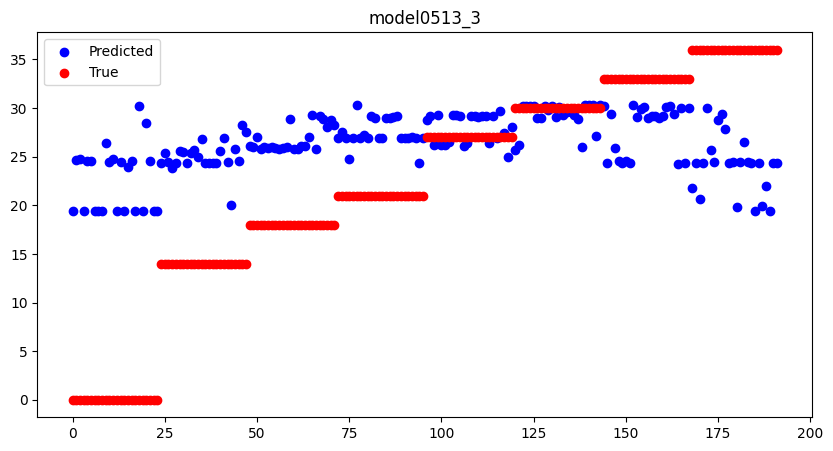

In [24]:
trained_model_paths = [
    # "./models/model0506_1/model.pt",
    # "./models/model0506_2/model.pt",
    # "./models/model0506_3/model.pt",
    # "./models/model0506_4/model.pt",
    # "./models/model0506_5/model.pt",
    # "./models/model0507_1/model.pt",
    # "./models/model0507_2/model.pt",
    # "./models/model0507_3/model.pt",
    # "./models/model0507_4/model.pt",
    # "./models/model0508_1/model.pt",
    # "./models/model0508_2/model.pt",
    # "./models/model0508_3/model.pt",
    # "./models/model0508_4/model.pt",
    # "./models/model0508_5/model.pt",
    # "./models/model0508_6/model.pt",
    # "./models/model0508_7/model.pt",
    "./models/model0513_3/model.pt",
]
for model_path in trained_model_paths:
    print(device)
    model = torch.load(model_path, map_location=torch.device('cpu'))
        
    print(model_path, end='\t')
    p,r = test_model(model, dataloader_test, print_prediction=True)
    print(p,r)
    xAxis = range(len(p))
    plt.figure(figsize=(10, 5))
    plt.title(model_path.split('/')[2])
    plt.scatter(xAxis, p, color='blue', label='Predicted')
    plt.scatter(xAxis, r,color='red', label='True')
    plt.legend()
    plt.plot()
    plt.show()

cpu
./models/model0508_1/model.pt	device: cpu


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9124\82047597.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.

Test MSE: 23.3660
[27.335899353027344, 16.31605339050293, 11.902252197265625, 12.988327026367188, 17.49408721923828, 26.83993148803711, 25.84549331665039, 14.68389892578125, 11.788715362548828, 11.763883590698242, 13.980345726013184, 12.975101470947266, 12.134857177734375, 12.39784049987793, 11.830864906311035, 10.55494499206543, 11.922159194946289, 16.6206111907959, 21.015113830566406, 13.586816787719727, 12.31263256072998, 11.387796401977539, 16.138458251953125, 17.797950744628906, 25.465307235717773, 12.170477867126465, 24.281784057617188, 18.62834358215332, 14.624469757080078, 11.650304794311523, 11.528799057006836, 11.323570251464844, 11.609893798828125, 12.544736862182617, 11.700770378112793, 11.912479400634766, 11.352473258972168, 12.21245002746582, 13.670307159423828, 14.957963943481445, 14.108107566833496, 12.275847434997559, 14.611042022705078, 13.17694091796875, 15.276336669921875, 19.82013702392578, 12.783474922180176, 12.465289115905762, 11.575725555419922, 24.260948181152

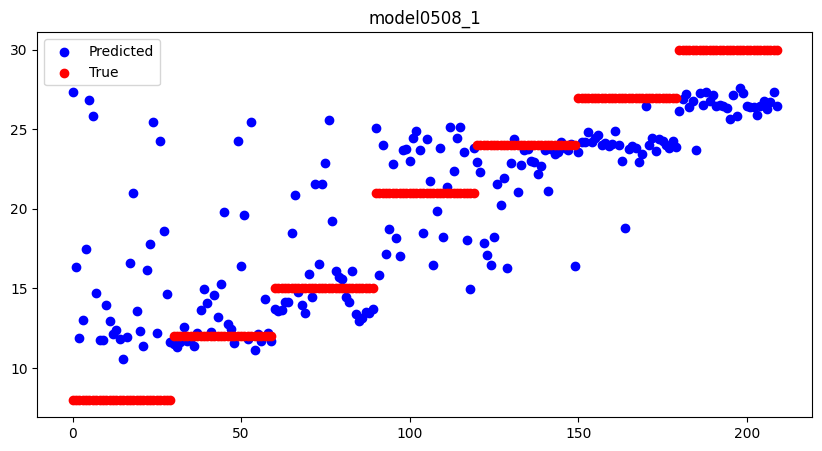

cpu
./models/model0508_2/model.pt	device: cpu
Test MSE: 30.1827
[25.70771026611328, 17.89870262145996, 15.897046089172363, 13.307062149047852, 14.696327209472656, 25.987518310546875, 24.964921951293945, 16.14269256591797, 13.426264762878418, 21.122692108154297, 17.961719512939453, 13.66012954711914, 23.9045352935791, 13.250850677490234, 14.261707305908203, 13.482681274414062, 13.75819206237793, 20.743223190307617, 18.636219024658203, 13.403597831726074, 12.81600570678711, 13.530451774597168, 24.11899757385254, 17.98354721069336, 17.052078247070312, 15.10093879699707, 14.503080368041992, 17.190366744995117, 13.617984771728516, 13.334890365600586, 13.830848693847656, 11.155902862548828, 11.404633522033691, 11.626912117004395, 12.123629570007324, 11.199109077453613, 10.982319831848145, 12.992878913879395, 13.397253036499023, 18.26029396057129, 14.286922454833984, 11.626761436462402, 15.424949645996094, 16.648069381713867, 22.665300369262695, 16.232616424560547, 14.042760848999023, 12.3804

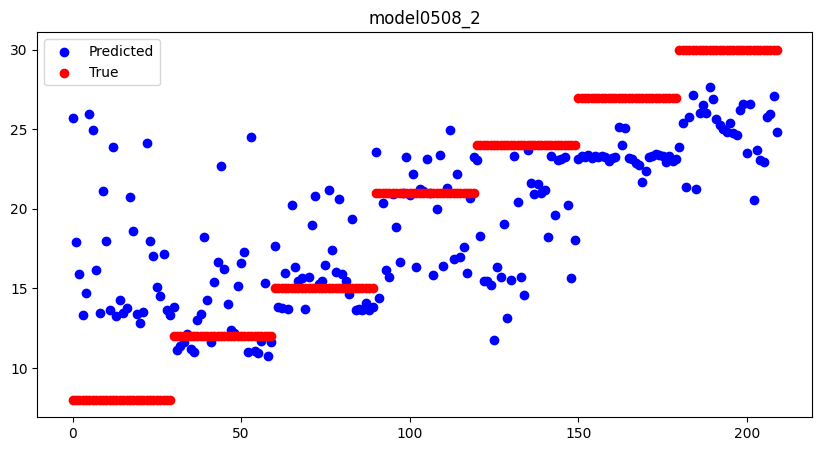

cpu
./models/model0508_3/model.pt	device: cpu
Test MSE: 34.4832
[27.266395568847656, 26.312673568725586, 19.09328269958496, 26.352832794189453, 12.759519577026367, 23.721166610717773, 27.509910583496094, 11.590168952941895, 18.544004440307617, 24.38760757446289, 25.10976791381836, 24.185474395751953, 25.657512664794922, 15.72164535522461, 12.20592975616455, 10.923578262329102, 15.501762390136719, 17.520933151245117, 15.374197006225586, 13.432090759277344, 11.716682434082031, 10.65481948852539, 24.029640197753906, 25.09744644165039, 24.63495445251465, 15.906018257141113, 19.909006118774414, 20.50542640686035, 17.40241050720215, 11.731402397155762, 11.188455581665039, 11.198418617248535, 10.969675064086914, 10.78520393371582, 11.690422058105469, 10.780013084411621, 10.742609977722168, 11.840726852416992, 16.909456253051758, 16.63035011291504, 17.756568908691406, 11.47031021118164, 16.055953979492188, 14.633265495300293, 14.4750394821167, 20.35965347290039, 13.219295501708984, 16.95175170

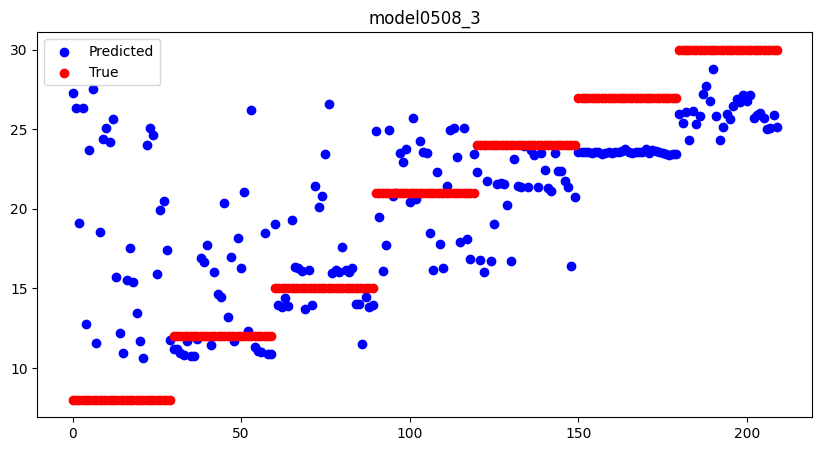

cpu
./models/model0508_4/model.pt	device: cpu
Test MSE: 39.5414
[26.289756774902344, 24.861961364746094, 26.173187255859375, 21.567062377929688, 22.151443481445312, 26.521106719970703, 26.563507080078125, 18.34030532836914, 22.84782600402832, 26.12649917602539, 25.443086624145508, 24.52307891845703, 25.936866760253906, 12.770312309265137, 11.469176292419434, 11.296174049377441, 15.302000045776367, 15.612204551696777, 13.76692008972168, 13.492410659790039, 13.297624588012695, 11.392550468444824, 26.035932540893555, 25.666072845458984, 26.142295837402344, 21.285602569580078, 23.738548278808594, 25.696805953979492, 20.725889205932617, 14.4180326461792, 11.796585083007812, 12.038887023925781, 13.88776969909668, 11.396453857421875, 11.490445137023926, 11.16617488861084, 11.387629508972168, 12.306413650512695, 21.80498695373535, 13.98121452331543, 13.940082550048828, 11.218489646911621, 14.270753860473633, 13.582906723022461, 21.63832664489746, 17.49799156188965, 14.765541076660156, 13.34639

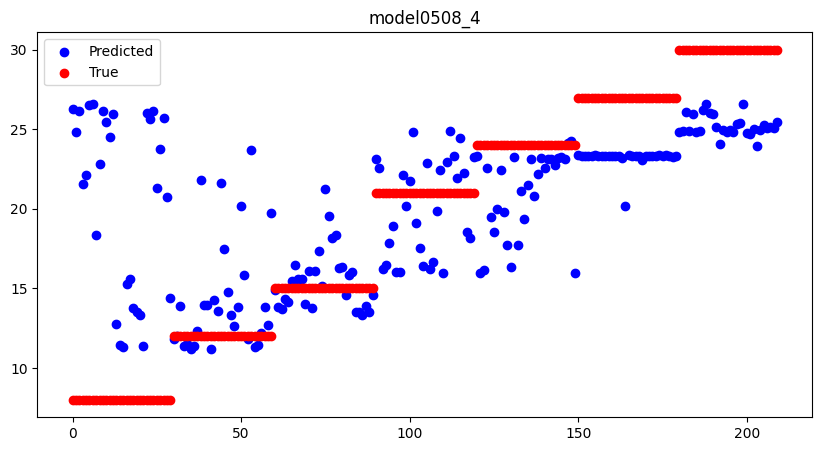

cpu
./models/model0508_5/model.pt	device: cpu
Test MSE: 32.9200
[29.51290512084961, 24.107332229614258, 17.716053009033203, 13.297075271606445, 21.230745315551758, 24.50065040588379, 24.912229537963867, 14.538636207580566, 17.609254837036133, 16.41323471069336, 22.727258682250977, 13.573319435119629, 20.468307495117188, 16.40373992919922, 15.428050994873047, 8.202171325683594, 14.651485443115234, 17.23789405822754, 18.110332489013672, 11.847092628479004, 11.256674766540527, 8.240605354309082, 27.223045349121094, 20.435279846191406, 19.907691955566406, 24.198719024658203, 23.477149963378906, 25.773921966552734, 21.90555191040039, 13.417364120483398, 10.249836921691895, 8.329570770263672, 8.260607719421387, 8.176533699035645, 9.824959754943848, 8.254314422607422, 8.449381828308105, 13.371686935424805, 16.433141708374023, 11.000980377197266, 14.706567764282227, 9.951766967773438, 14.142290115356445, 11.594112396240234, 11.500472068786621, 18.050474166870117, 12.439403533935547, 11.9386110

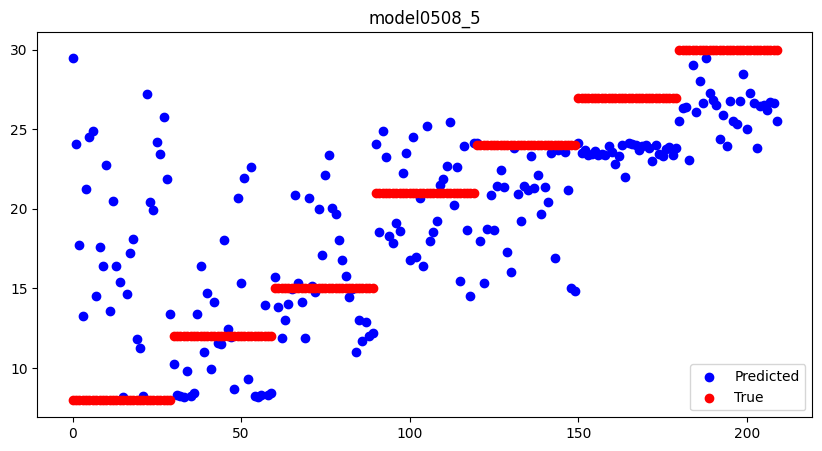

cpu
./models/model0508_6/model.pt	device: cpu
Test MSE: 46.8025
[29.211193084716797, 28.884746551513672, 20.911598205566406, 16.105676651000977, 25.844242095947266, 29.191082000732422, 29.046138763427734, 24.255159378051758, 18.428319931030273, 20.59384536743164, 29.127273559570312, 14.270747184753418, 27.9744873046875, 24.18699836730957, 15.36463737487793, 10.48766803741455, 17.524648666381836, 20.92190933227539, 20.96381378173828, 15.18990707397461, 14.364173889160156, 14.491893768310547, 26.506431579589844, 28.395366668701172, 24.243249893188477, 23.87659454345703, 28.868499755859375, 24.02218246459961, 27.384212493896484, 21.08025550842285, 16.1286678314209, 11.732012748718262, 18.636423110961914, 13.102851867675781, 18.68437957763672, 10.235499382019043, 10.557723045349121, 13.696430206298828, 15.256187438964844, 15.801733016967773, 16.657651901245117, 19.653671264648438, 18.29201889038086, 18.687414169311523, 24.698881149291992, 20.94768714904785, 14.958213806152344, 22.708984375

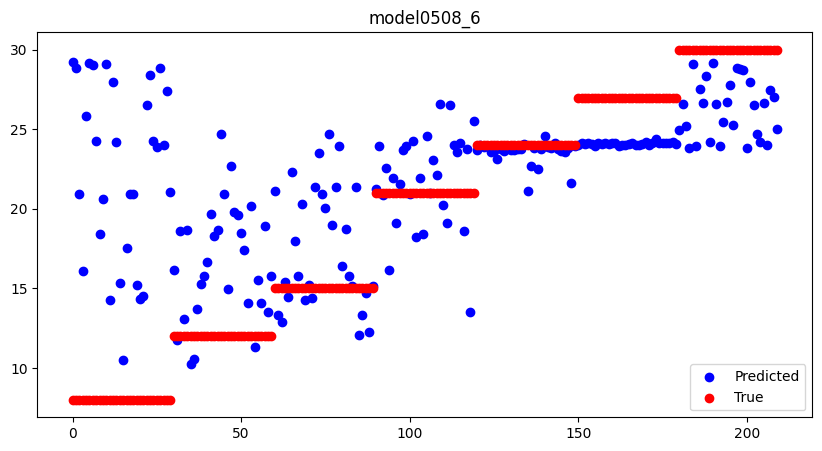

cpu
./models/model0508_7/model.pt	device: cpu
Test MSE: 37.3951
[29.892852783203125, 22.799894332885742, 29.426250457763672, 21.458309173583984, 13.392240524291992, 29.816383361816406, 25.721343994140625, 18.853952407836914, 11.91366195678711, 28.966907501220703, 29.81220245361328, 28.606504440307617, 21.58138656616211, 12.220233917236328, 11.298009872436523, 8.175257682800293, 13.778128623962402, 18.055124282836914, 13.165719985961914, 12.052967071533203, 11.787028312683105, 8.18838882446289, 27.00439453125, 17.373550415039062, 26.474512100219727, 15.19620132446289, 24.60821533203125, 15.876883506774902, 12.555315017700195, 11.692937850952148, 12.160325050354004, 8.56483268737793, 8.208117485046387, 8.12863540649414, 9.320320129394531, 8.119754791259766, 8.13210678100586, 16.585861206054688, 15.007558822631836, 18.87068748474121, 14.110513687133789, 12.648353576660156, 16.829326629638672, 12.779335021972656, 15.592948913574219, 14.995909690856934, 9.494235038757324, 11.713010787963867

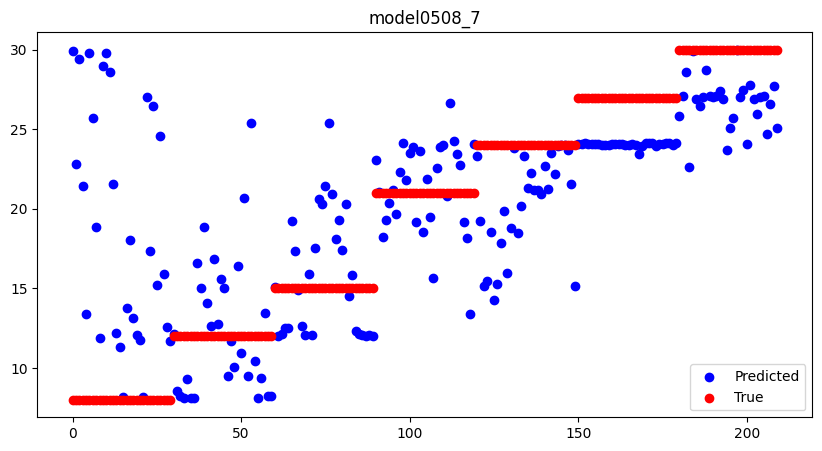

In [ ]:
trained_model_paths = [
    # "./models/model0506_1/model.pt",
    # "./models/model0506_2/model.pt",
    # "./models/model0506_3/model.pt",
    # "./models/model0506_4/model.pt",
    # "./models/model0506_5/model.pt",
    # "./models/model0507_1/model.pt",
    # "./models/model0507_2/model.pt",
    # "./models/model0507_3/model.pt",
    # "./models/model0507_4/model.pt",
    "./models/model0508_1/model.pt",
    "./models/model0508_2/model.pt",
    "./models/model0508_3/model.pt",
    "./models/model0508_4/model.pt",
    "./models/model0508_5/model.pt",
    "./models/model0508_6/model.pt",
    "./models/model0508_7/model.pt",
]
for model_path in trained_model_paths:
    print(device)
    model = torch.load(model_path, map_location=torch.device('cpu'))
        
    print(model_path, end='\t')
    p,r = test_model(model, dataloader_test, print_prediction=False)
    print(p,r)
    xAxis = range(len(p))
    plt.figure(figsize=(10, 5))
    plt.title(model_path.split('/')[2])
    plt.scatter(xAxis, p, color='blue', label='Predicted')
    plt.scatter(xAxis, r,color='red', label='True')
    plt.legend()
    plt.plot()
    plt.show()

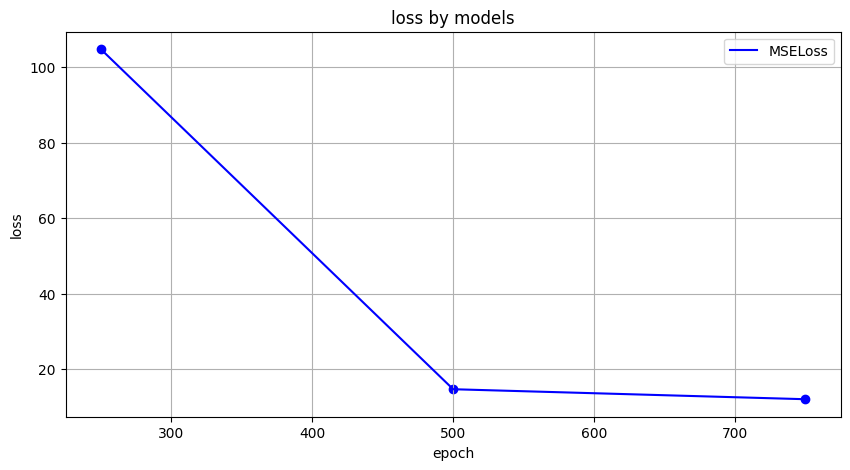

In [6]:
import matplotlib.pyplot as plt
x = [250,500,750]
y = [104.7259, 14.7021, 12.0556]
plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='Blue')
plt.plot(x, y, color='blue', label='MSELoss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by models')
plt.legend()
plt.grid()
plt.show()

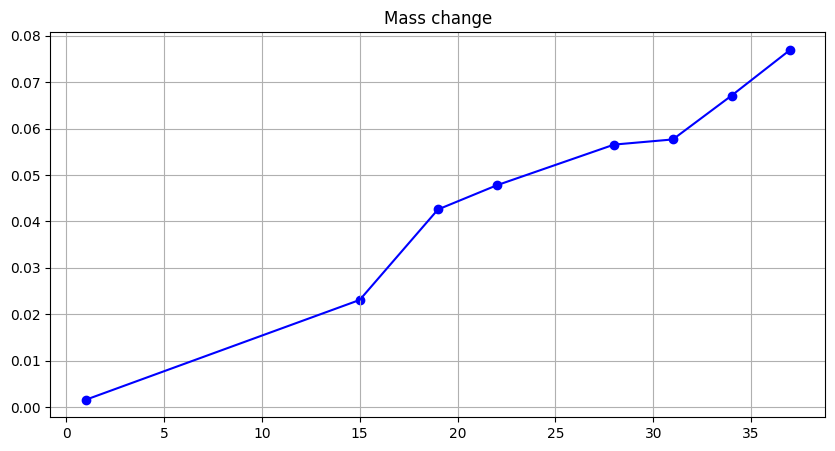

In [2]:
import matplotlib.pyplot as plt
x = [37, 34, 31, 28, 22, 19, 15, 1]
y = [0.076972059, 0.067101433,0.057661799,0.056554394,0.047782559,0.042582537,0.023096565,0.001597278]

plt.figure(figsize=(10, 5))
plt.grid()
plt.title('Mass change')
plt.scatter(x, y, color='blue', label='Mass change')
plt.plot(x, y, color='blue')
plt.show()

In [2]:
!pip install hiddenlayer

In [13]:
import torch
from torchviz import make_dot
from model import InceptionNetwork

# 모델 생성 및 가중치 로드

model = torch.load("./models/model0513_3/model.pt", map_location="cpu")
model.eval()

# 더미 입력을 통한 시각화
dummy_input = torch.zeros([1, 3, 100])
output = model(dummy_input)

# 시각화 생성 및 저장
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("inception_model_torchviz", format="png")


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13296\3553009602.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./models/model0513_3/model.p

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH